In [1]:
import os
import glob
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics


# Tensorflow import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, ReLU, Softmax, BatchNormalization, Dropout
from tensorflow.random import set_seed

In [2]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric]);
        ax[idx].legend([metric, 'val_' + metric])
    
def ConfusionMatrix(model, ds, label_list):
# Note: This logic doesn't work with shuffled datasets
    plt.figure(figsize=(15,10))
    y_pred = model.predict(ds)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in ds], axis=0)
    cm = metrics.confusion_matrix(true_categories,predicted_categories) # last batch 
    sns.heatmap(cm, annot=True, xticklabels=label_list, yticklabels=label_list, cmap="YlGnBu", fmt='g')
    plt.show()
    
def testAccuracy(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    predicted_categories = tf.argmax(y_pred, axis=1)
    test_acc = metrics.accuracy_score(true_categories, predicted_categories) * 100
    print(f'\nTest Accuracy: {test_acc:.2f}%\n')
    
def plot_image(pred_array, true_label, img, class_names):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(pred_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ".format(class_names[predicted_label],
                                100*np.max(pred_array),
                                ),
                                color=color)

def predictions(model):
    true_categories = tf.concat([y for x, y in test_ds], axis=0)
    images = tf.concat([x for x, y in test_ds], axis=0)
    y_pred = model.predict(test_ds)
    class_names = test_data.class_names
    # Randomly sample 15 test images and plot it with their predicted labels, and the true labels.
    indices = random.sample(range(len(images)), 36)
    # Color correct predictions in blue and incorrect predictions in red.
    num_rows = 6
    num_cols = 6
    num_images = num_rows*num_cols
    plt.figure(figsize=(4*num_cols, 2*num_rows))
    for i,index in enumerate(indices):
        plt.subplot(num_rows, num_cols, i+1)
        plot_image(y_pred[index], true_categories[index], images[index],class_names)
    plt.tight_layout()
    plt.show()

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("final_model.h5", save_best_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",patience=5, restore_best_weights=True
)

In [3]:
set_seed(111) # set random seed

# To supress any warnings during the flow
import warnings
warnings.filterwarnings('ignore')

In [4]:
class_dirs = os.listdir("hinh/train") # list all directories inside "train" folder

image_dict = {} # dict to store image array(key) for every class(value)

count_dict = {} # dict to store count of files(key) for every class(value)

# iterate over all class_dirs
for cls in class_dirs:
    # get list of all paths inside the subdirectory
    file_paths = glob.glob(f'hinh/train/{cls}/*')
    # count number of files in each class and add it to count_dict
    count_dict[cls] = len(file_paths)
    # select random item from list of image paths
    image_path = random.choice(file_paths)
    # load image using keras utility function and save it in image_dict
    image_dict[cls] = tf.keras.utils.load_img(image_path)

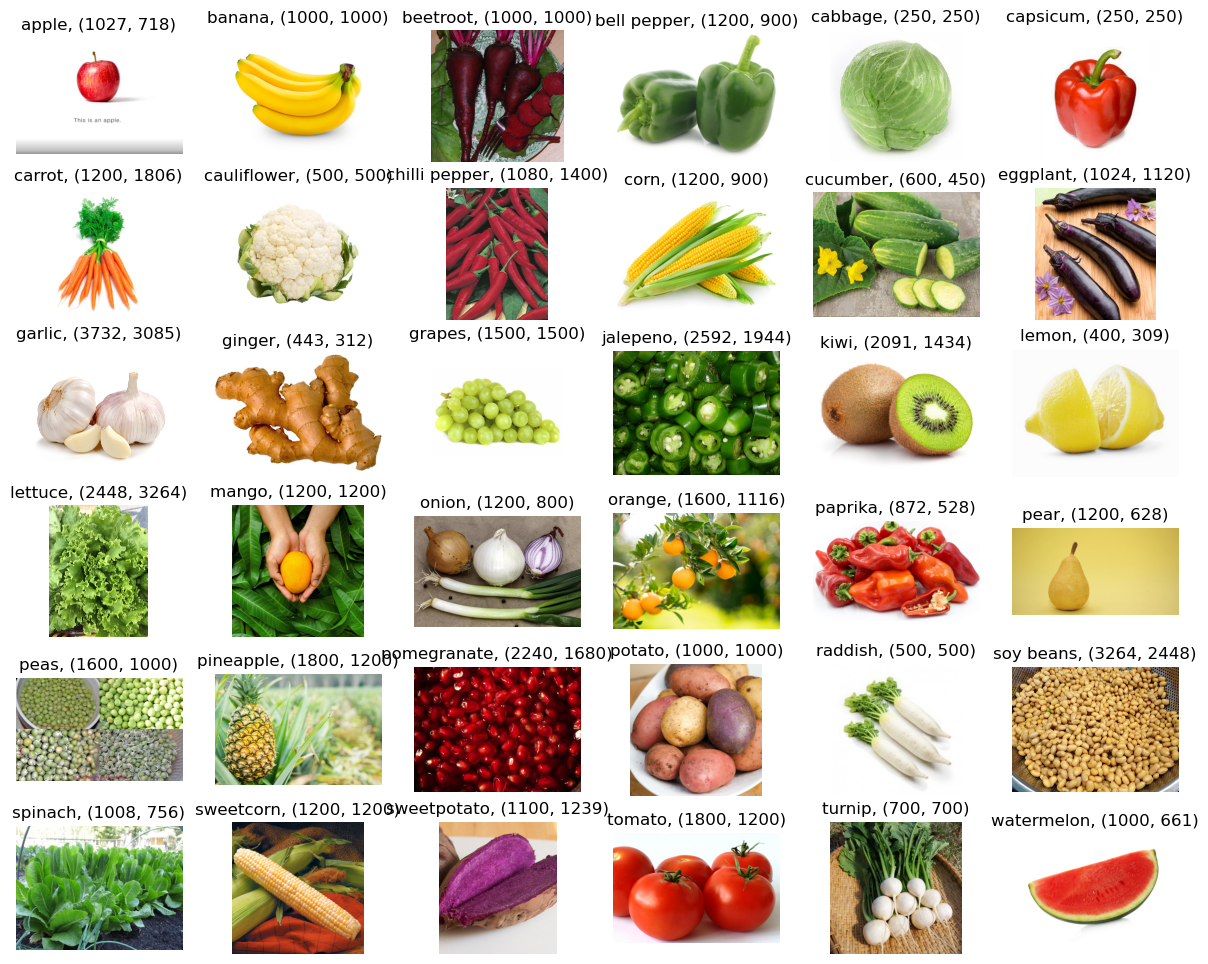

In [5]:
## Viz Random Sample from each class
plt.figure(figsize=(15, 12))
# iterate over dictionary items (class label, image array)
for i, (cls,img) in enumerate(image_dict.items()): 
    # create a subplot axis
    ax = plt.subplot(6, 6, i + 1)
    # plot each image
    plt.imshow(img)
    # set "class name" along with "image size" as title 
    plt.title(f'{cls}, {img.size}')
    plt.axis("off")

In [6]:
## Let's now Plot the Data Distribution of Training Data across Classes
df_count_train = pd.DataFrame({
    "class": count_dict.keys(),     # keys of count_dict are class labels
    "count": count_dict.values(),   # value of count_dict contain counts of each class
})
print("Số lượng mẫu huấn luyện cho mỗi lớp:\n", df_count_train)

Số lượng mẫu huấn luyện cho mỗi lớp:
             class  count
0           apple     63
1          banana     75
2        beetroot     85
3     bell pepper     85
4         cabbage     87
5        capsicum     84
6          carrot     72
7     cauliflower     74
8   chilli pepper     87
9            corn     87
10       cucumber     94
11       eggplant     84
12         garlic     92
13         ginger     68
14         grapes    100
15       jalepeno     88
16           kiwi     88
17          lemon     82
18        lettuce     97
19          mango     86
20          onion     94
21         orange     69
22        paprika     83
23           pear     89
24           peas    100
25      pineapple     99
26    pomegranate     79
27         potato     77
28        raddish     81
29      soy beans     97
30        spinach     97
31      sweetcorn     91
32    sweetpotato     69
33         tomato     92
34         turnip     98
35     watermelon     84


<Figure size 1500x1200 with 0 Axes>

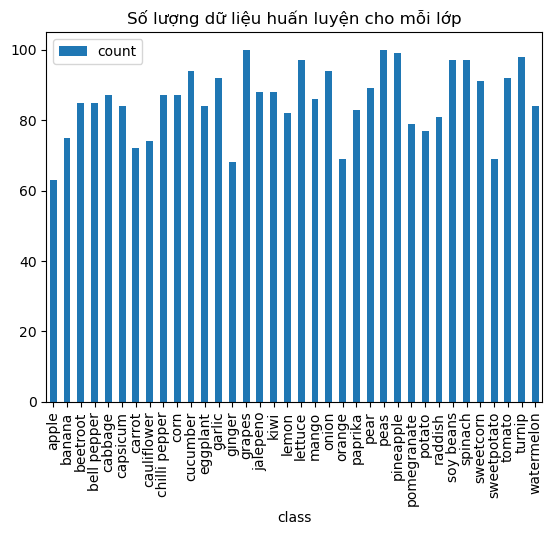

In [7]:
# draw a bar plot using pandas in-built plotting function
plt.figure(figsize=(15,12))
df_count_train.plot.bar(x='class', y='count', title="Số lượng dữ liệu huấn luyện cho mỗi lớp") 
plt.show()

In [8]:
print('\nLoading Train Data...')
train_data = tf.keras.utils.image_dataset_from_directory(
    "hinh/train", shuffle = True,
)

print('\nLoading Validation Data...')
val_data = tf.keras.utils.image_dataset_from_directory(
    "hinh/validation", shuffle = False,
)

print('\nLoading Test Data...')
test_data = tf.keras.utils.image_dataset_from_directory(
    "hinh/test", shuffle = False,
)


Loading Train Data...
Found 3077 files belonging to 36 classes.

Loading Validation Data...
Found 351 files belonging to 36 classes.

Loading Test Data...
Found 359 files belonging to 36 classes.


In [9]:
height, width = 224, 224

# Data Processing Stage with resizing and rescaling operations
data_preprocess = keras.Sequential(
    name="data_preprocess",
    layers=[
        layers.Resizing(height, width), # Shape Preprocessing
        layers.Rescaling(1.0/255), # Value Preprocessing
    ]
)

# Perform Data Processing on the train, val, test dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))
test_ds = test_data.map(lambda x, y: (data_preprocess(x), y))

In [10]:
pretrained_resnet_model = tf.keras.applications.ResNet50V2(weights='imagenet',
                         include_top=False,
                         input_tensor = (tf.keras.layers.Input(shape=(height,width,3)))
                         )
pretrained_resnet_model.trainable=False
resnet_model = tf.keras.Sequential([
    pretrained_resnet_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(36, activation='softmax')
])

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 36)                73764     
                                                                 
Total params: 23,638,564
Trainable params: 73,764
Non-trainable params: 23,564,800
_________________________________________________________________


In [12]:
resnet_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
history_resnet = resnet_model.fit(train_ds, epochs=100, validation_data=val_ds, callbacks=[checkpoint_callback,early_stopping_callback])

Epoch 1/100
97/97 [==============================] - 268s 3s/step - loss: 1.6992 - accuracy: 0.5395 - val_loss: 0.5090 - val_accuracy: 0.8746
Epoch 2/100
97/97 [==============================] - 245s 2s/step - loss: 0.6499 - accuracy: 0.8102 - val_loss: 0.3768 - val_accuracy: 0.8832
Epoch 3/100
97/97 [==============================] - 263s 3s/step - loss: 0.4346 - accuracy: 0.8801 - val_loss: 0.3160 - val_accuracy: 0.9145
Epoch 4/100
97/97 [==============================] - 246s 2s/step - loss: 0.3125 - accuracy: 0.9249 - val_loss: 0.2614 - val_accuracy: 0.9259
Epoch 5/100
97/97 [==============================] - 228s 2s/step - loss: 0.2300 - accuracy: 0.9496 - val_loss: 0.2352 - val_accuracy: 0.9316
Epoch 6/100
97/97 [==============================] - 231s 2s/step - loss: 0.1891 - accuracy: 0.9584 - val_loss: 0.1973 - val_accuracy: 0.9544
Epoch 7/100
97/97 [==============================] - 225s 2s/step - loss: 0.1473 - accuracy: 0.9714 - val_loss: 0.2017 - val_accuracy: 0.9487
Epoch 

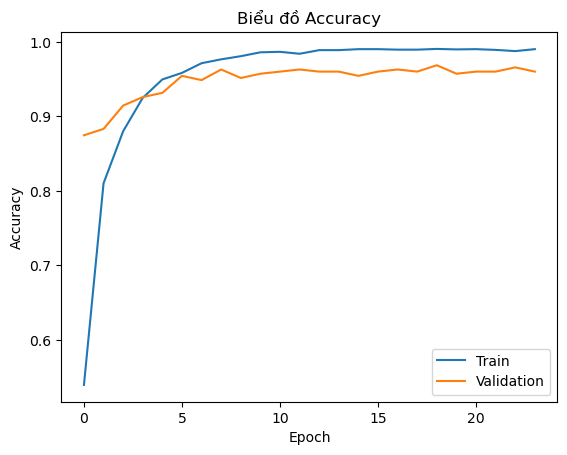

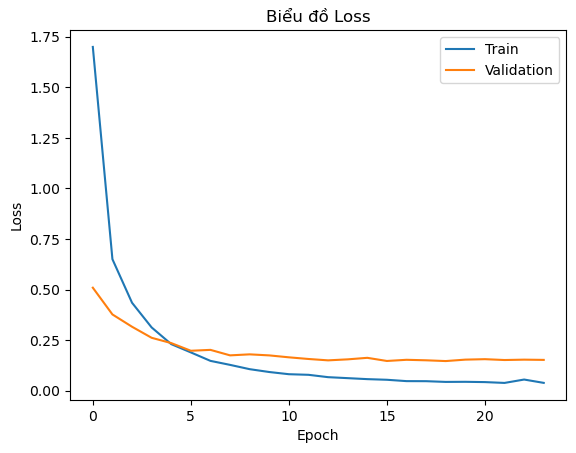

In [14]:
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('Biểu đồ Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Plot loss
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('Biểu đồ Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [15]:
testAccuracy(resnet_model)

12/12 [==============================] - 49s 2s/step

Test Accuracy: 96.94%



12/12 [==============================] - 25s 2s/step


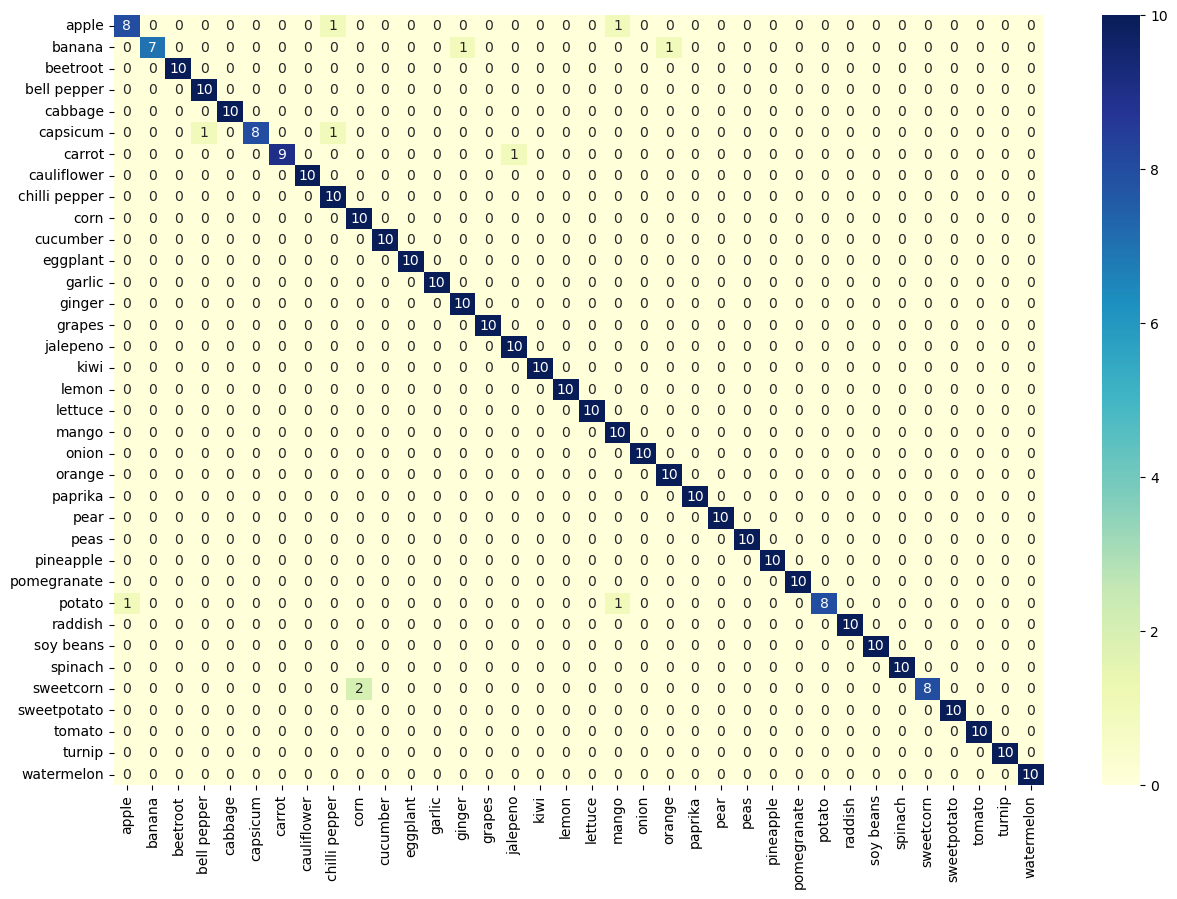

In [16]:
ConfusionMatrix(resnet_model, test_ds, test_data.class_names)

In [17]:
resnet_model.save('resnet_model.h5')